In [3]:
from pathlib import Path
import yaml
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
os.chdir(Path('/gpfs-calypso/home/globc/garcia/'))

from ClimateBench.funcs.settings import CONFIGS_DIR, GRAPHS_DIR
from ClimateBench.funcs.dataloader import get_dataloaders


In [4]:
exp = 'exp1'
with open(CONFIGS_DIR / f'config_{exp}.yaml') as file:
        config = yaml.safe_load(file)
with open(CONFIGS_DIR / f'config_plots.yaml') as file:
        config_plots = yaml.safe_load(file)

In [5]:
data_type = 'train'
dataloader = get_dataloaders(data_type=data_type, config=config, transforms=False)

inputs = []
outputs = []
for i, batch in enumerate(dataloader):
    x, y = batch
    inputs.append(x)
    outputs.append(y)
inputs = np.concatenate(inputs, 0)
outputs = np.concatenate(outputs, 0)
print(inputs.shape, outputs.shape)
    

(580, 10, 96, 144, 4) (580, 1, 96, 144)


In [8]:
def plot_multi_samples_time_series(data, 
                                   n_rows=2, 
                                   n_cols=3,
                                   title=None,
                                   unit=None,
                                   var_name=None):
    """
    Trace aléatoirement plusieurs séries temporelles dans une grille, 
    affiche la pente moyenne sur chaque mini-figure et retourne la figure 
    ainsi que le nombre de séries dont la pente est positive et négative.

    Parameters
    ----------
    data : np.ndarray
        Tableau de forme (n_exemples, longueur_série)
    n_rows : int
        Nombre de lignes dans la grille de sous-figures
    n_cols : int
        Nombre de colonnes dans la grille de sous-figures

    Returns
    -------
    fig : matplotlib.figure.Figure
        La figure contenant les graphiques
    n_pos : int
        Nombre de séries avec une pente positive
    n_neg : int
        Nombre de séries avec une pente négative
    """

    n_examples = data.shape[0]
    total_plots = n_rows * n_cols

    # Sélection aléatoire d'indices uniques
    indices = np.random.choice(n_examples, total_plots, replace=False)
    data_selected = data[indices]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.ravel()
    print('coef')
    x = np.arange(data.shape[1]).reshape(-1, 1)
    coefs = [LinearRegression().fit(x, data[i,:].reshape(-1, 1)).coef_[0][0] for i in range(data.shape[0])]
    coefs = np.array(coefs)
    coefs_selected = coefs[indices]
    print(coefs.shape, coefs_selected.shape)
    print(coefs[coefs < 0])
    
    for i, serie in enumerate(data_selected):
        ax = axes[i]

        # Calcul pente
        y = serie.reshape(-1, 1)
        slope = coefs_selected[i]

        ax.plot(serie, linewidth=2)
        if slope < 1e-2 and slope > -1e-2:
            ax.set_title(f"Pente = {slope:.2e}", fontsize=14)
        else: 
            ax.set_title(f"Pente = {slope:.2f}", fontsize=14)
        ax.set_ylim(data.min(), data.max())
        ax.grid(True, alpha=0.5)
        ax.tick_params(labelsize=14)
        

        # Gestion des axes visibles
        row = i // n_cols
        col = i % n_cols

        show_xaxis = (row == n_rows - 1)    # dernière ligne
        show_yaxis = (col == 0)            # première colonne

        if not show_xaxis:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Year', fontsize=12)

        if not show_yaxis:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(f'{var_name} {unit}', fontsize=12)

    # Masquer cases vides si nécessaire
    for j in range(i+1, total_plots):
        axes[j].axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()

    nb_pos = len(coefs[coefs > 0])
    nb_neg = len(coefs[coefs < 0])
    plt.subplots()
    plt.hist(coefs, histtype='step', density=True, bins=100, linewidth=2)
    plt.text(0.6 * coefs.max(), 0.06, f'Nb positive trend: {nb_pos} \nNb negative trend: {nb_neg}') 
    plt.axvline(np.mean(coefs), linestyle='--', linewidth=2)
    plt.xlabel(f'10 years mean trend ({unit})')
    return coefs


coef
(580,) (36,)
[-5.95073242 -5.75132428 -6.09235174 -4.63124408 -1.88726474 -2.46969253
 -4.1189024  -1.2735825  -6.06708688 -5.08506747 -6.00890891 -0.62415069
 -5.94913589 -6.05915749 -3.57361506 -3.02836618 -5.46206942]


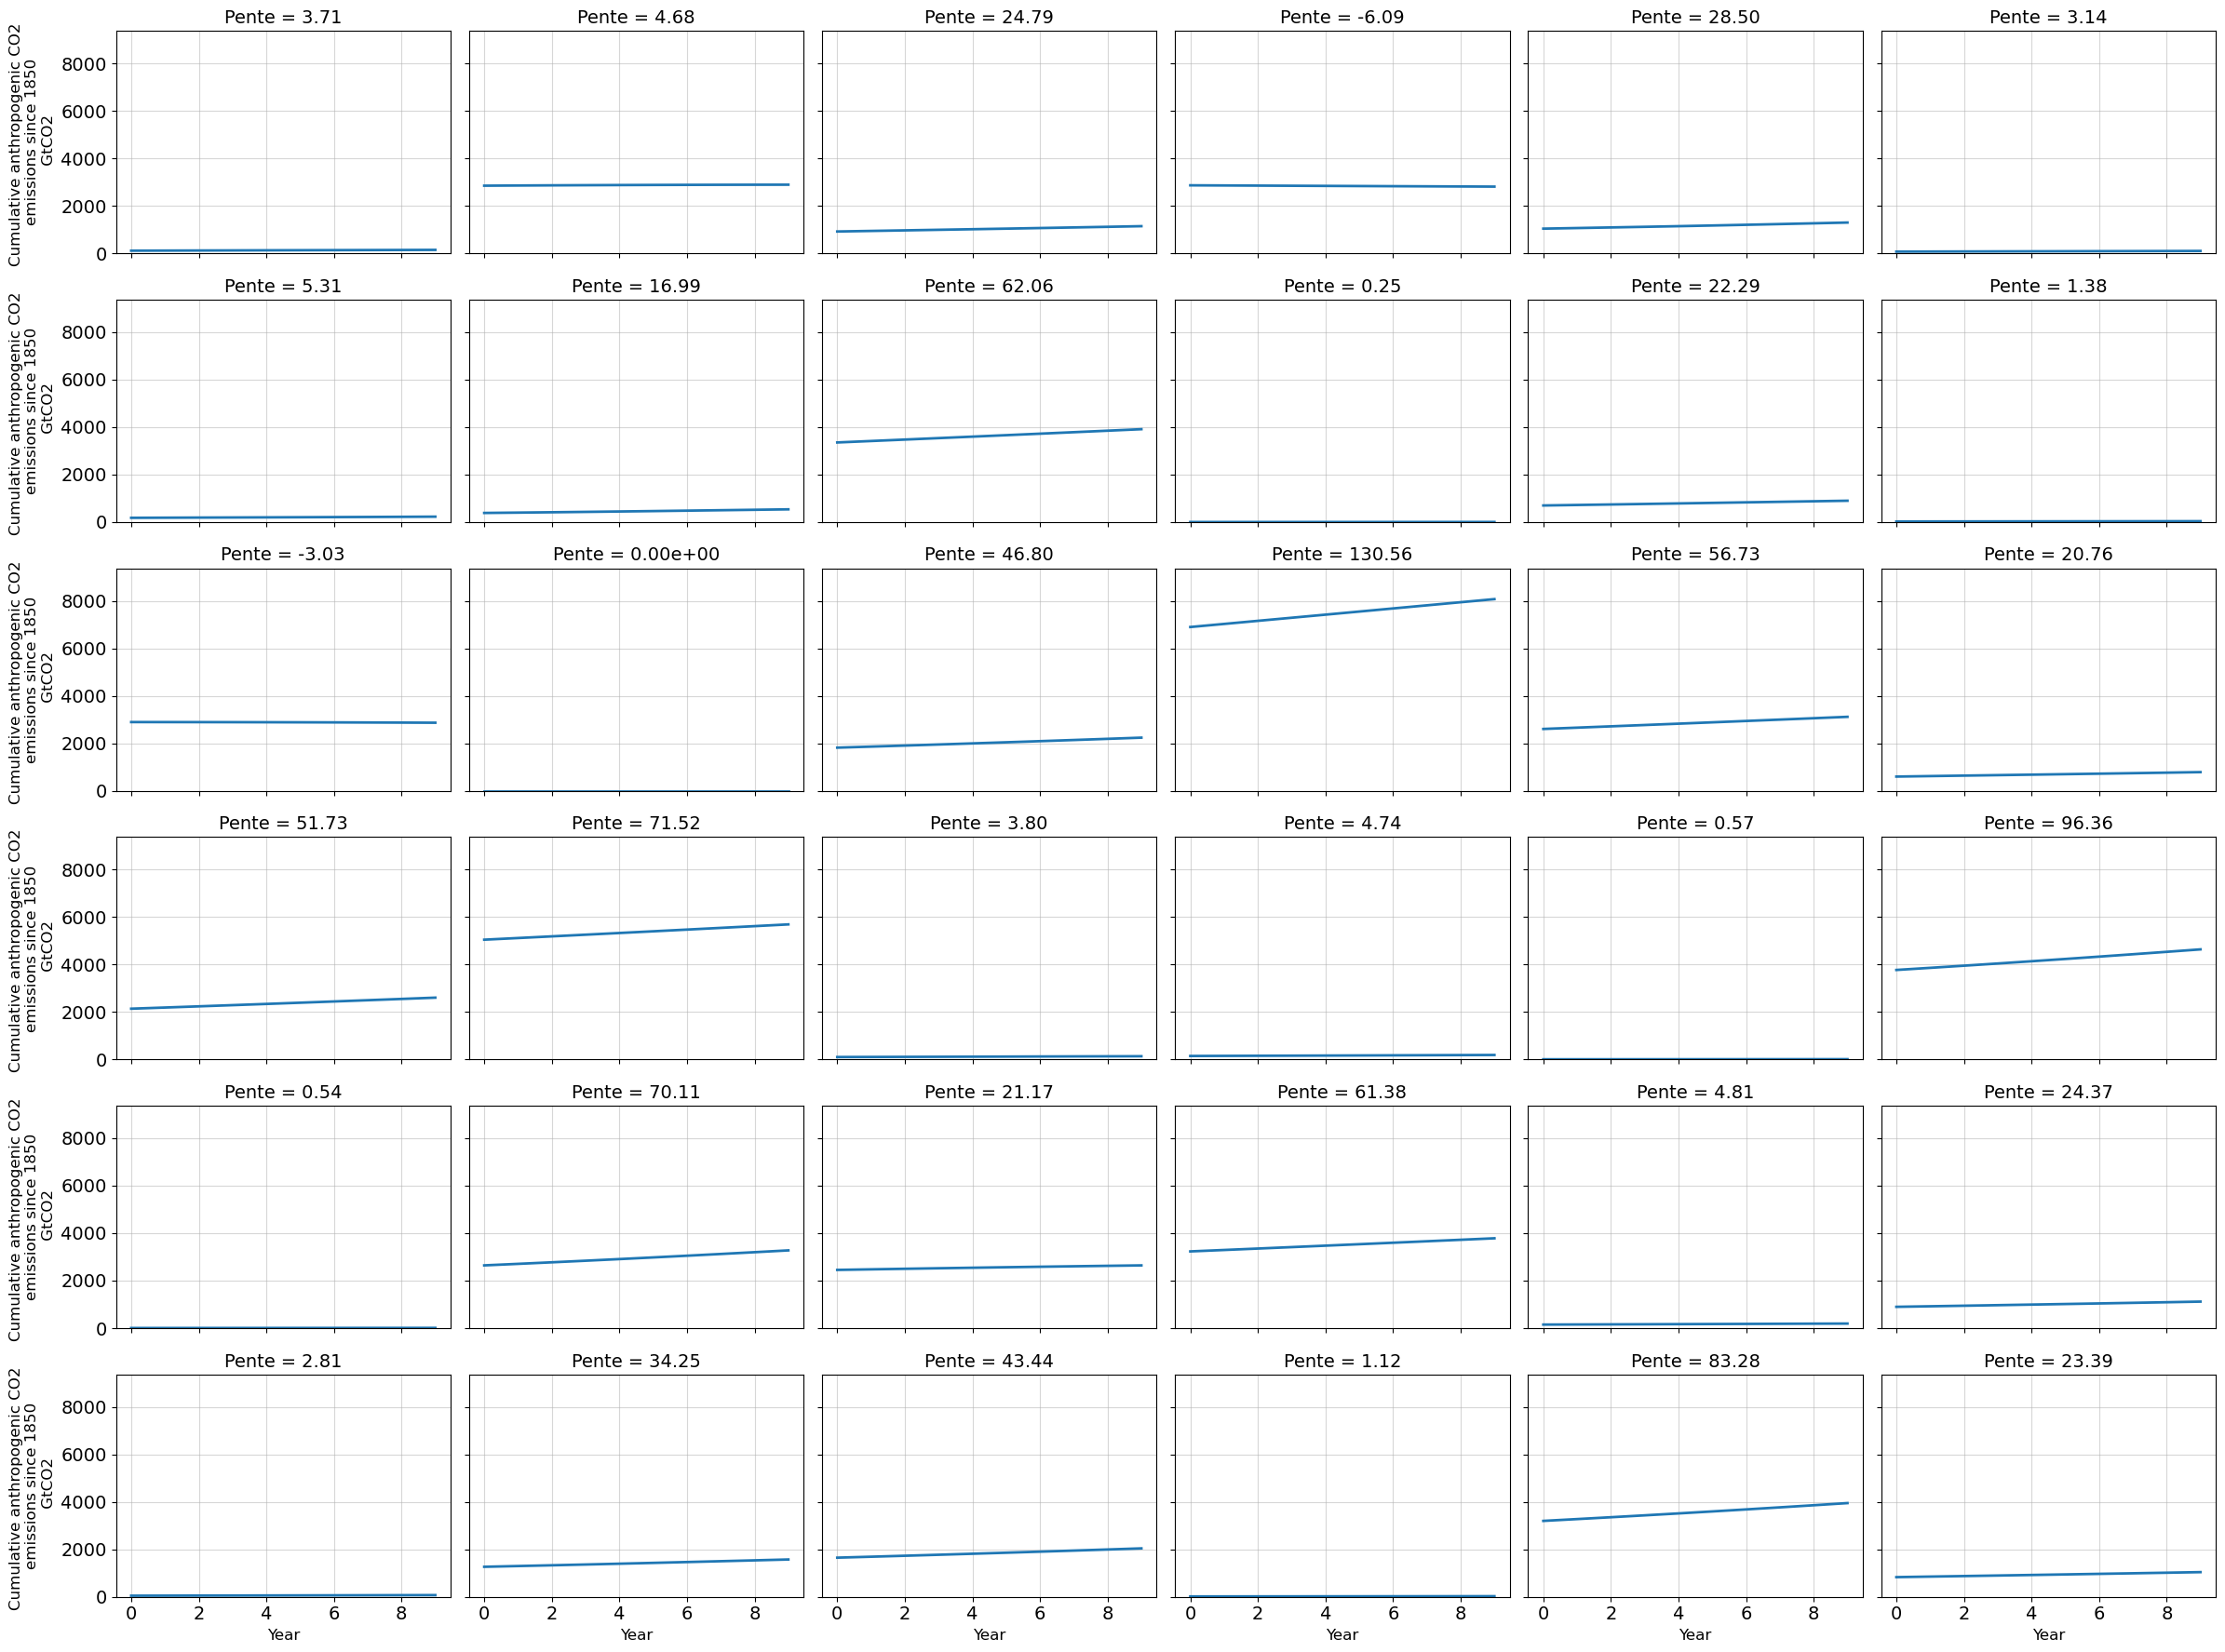

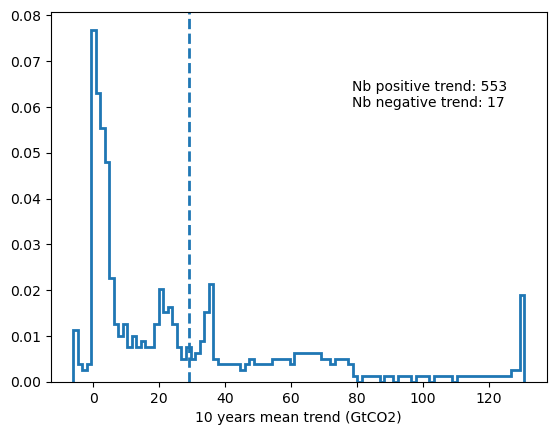

In [9]:
var = 'CO2'
var_idx = config['data']['vars'].index(var)

coefs = plot_multi_samples_time_series(np.mean(inputs[...,var_idx], axis=(2,3)),
                                                  n_rows=6,
                                                  n_cols=6,
                                                  var_name = config_plots['inputs'][var]['longname'],
                                                  unit = config_plots['inputs'][var]['unit'])